In [52]:
#Install requirements
# !pip install opencv-python-headless matplotlib scikit-image torch torchvision
# !pip install git+https://github.com/facebookresearch/segment-anything.git

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.graph import route_through_array
from scipy.ndimage import distance_transform_edt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

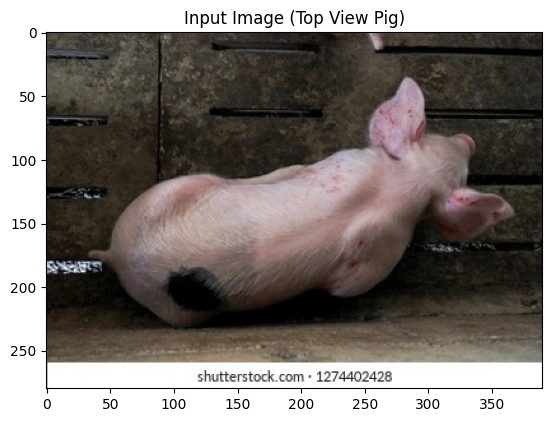

In [54]:
image_path = "pig.jpeg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title("Input Image (Top View Pig)")
plt.show()

In [55]:
sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mask_generator = SamAutomaticMaskGenerator(sam)


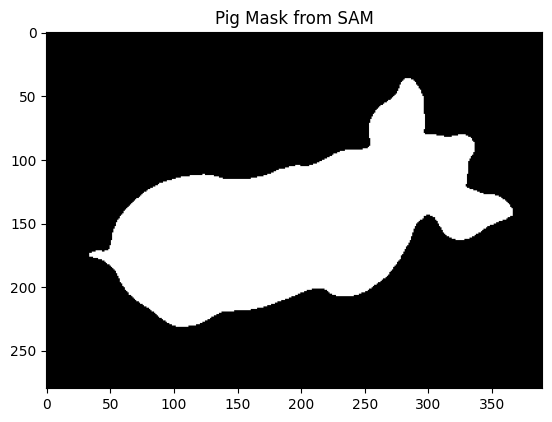

In [56]:
masks = mask_generator.generate(image_rgb)
# Take the largest mask (pig body)
pig_mask = max(masks, key=lambda x: np.sum(x['segmentation']))['segmentation']

plt.imshow(pig_mask, cmap="gray")
plt.title("Pig Mask from SAM")
plt.show()

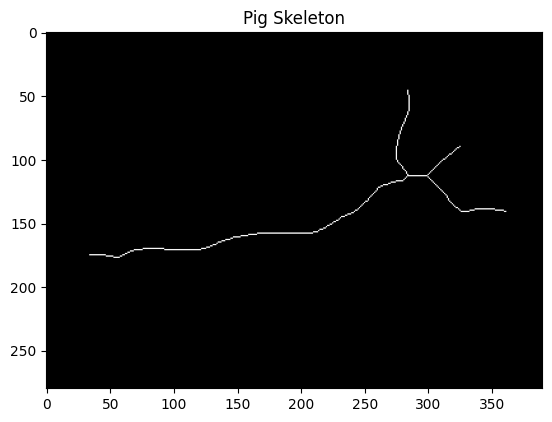

In [57]:
skeleton = skeletonize(pig_mask)

plt.imshow(skeleton, cmap="gray")
plt.title("Pig Skeleton")
plt.show()

In [58]:
def find_endpoints(skel):
    endpoints = []
    h, w = skel.shape
    for y in range(1, h-1):
        for x in range(1, w-1):
            if skel[y, x]:
                neighbors = np.sum(skel[y-1:y+2, x-1:x+2]) - 1
                if neighbors == 1:
                    endpoints.append((y, x))
    return endpoints

endpoints = find_endpoints(skeleton)
print("Endpoints:", endpoints)

Endpoints: [(46, 284), (90, 325), (141, 361), (175, 34)]


In [59]:
def endpoint_width(mask, point):
    """Estimate local width around endpoint using distance transform"""
    y, x = point
    dist = distance_transform_edt(mask)
    return dist[y, x] * 2  # approx diameter at that point

widths = [endpoint_width(pig_mask, ep) for ep in endpoints]
head_idx = np.argmin(widths)  # narrower side = head
tail_idx = 1 - head_idx

head_point = endpoints[head_idx]
tail_point = endpoints[tail_idx]

print("Head point:", head_point, "Tail point:", tail_point)

Head point: (175, 34) Tail point: (141, 361)


In [60]:
def analyze_skeleton(mask, skeleton, endpoints, width_jump_ratio=1.5, window=10):
    """
    Analyze skeleton path and determine head, neck, tail correctly.
    """
    # Try both endpoint orders
    cost = np.where(skeleton, 1, 999999)
    path1, _ = route_through_array(cost, endpoints[0], endpoints[1], fully_connected=True)
    path2 = path1[::-1]  # reverse

    dist_transform = distance_transform_edt(mask)

    def path_widths(path):
        return [dist_transform[y, x] * 2 for y, x in path]

    w1 = path_widths(path1)
    w2 = path_widths(path2)

    def find_neck(path, widths):
        for i in range(window, len(widths)-window):
            if widths[i] > width_jump_ratio * widths[0]:
                return path[i], path[i:]
        return path[0], path  # fallback

    # Try both directions
    neck1, body1 = find_neck(path1, w1)
    neck2, body2 = find_neck(path2, w2)

    # Choose direction where widths grow more clearly (head → neck → body)
    growth1 = max(w1) / (w1[0] + 1e-5)
    growth2 = max(w2) / (w2[0] + 1e-5)

    if growth1 > growth2:
        head, neck, tail = path1[0], neck1, path1[-1]
        body_path = body1
    else:
        head, neck, tail = path2[0], neck2, path2[-1]
        body_path = body2

    return head, neck, tail, body_path

# --- Use improved method ---
head_point, neck_point, tail_point, neck_to_tail_path = analyze_skeleton(
    pig_mask, skeleton, endpoints
)

In [61]:
# def skeleton_path_length(skel, start, end, trim=30):
#     """Find path along skeleton, trimming 'trim' pixels from head side"""
#     cost = np.where(skel, 1, 999999)
#     path, dist = route_through_array(cost, start, end, fully_connected=True)
    
#     # Trim the head region from path
#     if trim > 0:
#         path = path[trim:]  # cut first N pixels near head
#         dist = len(path)
#     return dist, path

# length_px, path = skeleton_path_length(skeleton, head_point, tail_point, trim=30)
# print(f"Body length (neck-to-tail) in pixels: {length_px}")

In [62]:
# def longest_skeleton_path(skel, endpoints):
#     max_len = 0
#     best_pair = None
#     for i in range(len(endpoints)):
#         for j in range(i+1, len(endpoints)):
#             start, end = endpoints[i], endpoints[j]
#             cost = np.where(skel, 1, 999999)  # skeleton pixels = 1, background = high cost
#             path, dist = route_through_array(cost, start, end, fully_connected=True)
#             if dist > max_len:
#                 max_len = dist
#                 best_pair = (start, end)
#     return max_len, best_pair

# length_px, best_pair = longest_skeleton_path(skeleton, endpoints)
# print(f"Body length (pixels): {length_px}")

In [63]:
body_length_px = len(neck_to_tail_path)
print(f"Body length (neck-to-tail) in pixels: {body_length_px}")

Body length (neck-to-tail) in pixels: 98


In [64]:
scale = 1/5.0  # cm per pixel
body_length_cm = body_length_px * scale
print(f"Body length (cm): {body_length_cm:.2f}")

Body length (cm): 19.60


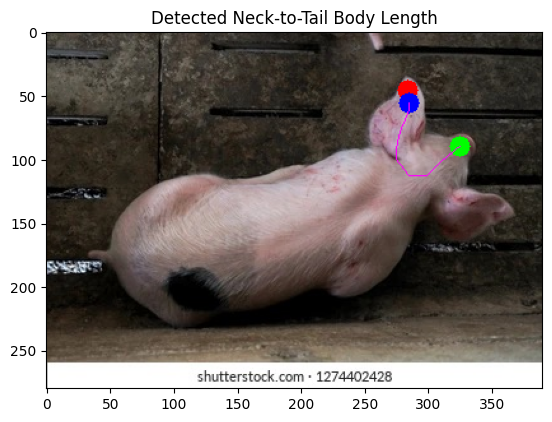

In [65]:
vis = image_rgb.copy()
cv2.circle(vis, (head_point[1], head_point[0]), 8, (255,0,0), -1)   # head = red
cv2.circle(vis, (neck_point[1], neck_point[0]), 8, (0,0,255), -1)   # neck = blue
cv2.circle(vis, (tail_point[1], tail_point[0]), 8, (0,255,0), -1)   # tail = green
for y, x in neck_to_tail_path:
    vis[y, x] = (255, 0, 255)  # magenta path

plt.imshow(vis)
plt.title("Detected Neck-to-Tail Body Length")
plt.show()